In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# CIFAR-10-C
# dataset_dir = '/kaggle/input/cifar-c'
# print(os.listdir(dataset_dir))
# # Define the path to the subdirectory
# sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
# # List contents of the subdirectory
# print(os.listdir(sub_dir))

# CIFAR-100-C
dataset_dir = '/kaggle/input/cifar-100-c'
print(os.listdir(dataset_dir))

['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'README.txt', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/866.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 14.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1799, done.


remote: Counting objects: 100% (415/415), done.


remote: Compressing objects: 100% (281/281), done.


remote: Total 1799 (delta 159), reused 384 (delta 134), pack-reused 1384 (from 1)
Receiving objects: 100% (1799/1799), 622.84 MiB | 34.34 MiB/s, done.
Resolving deltas: 100% (822/822), done.


Updating files: 100% (169/169), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 512

# Use CIFAR-10 dataset for training
# num_classes = 10    # CIFAR-10
# baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform_train)
# baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2, pin_memory=True)

# # Use CIFAR-10 dataset for testing
# baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform_test)
# baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2, pin_memory=True)

# # Use CIFAR-100 dataset for training
num_classes = 100   # CIFAR-100
baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)

# Use CIFAR-100 dataset for testing
baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1725198837.361369      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 65536/169001437 [00:00<07:45, 362819.09it/s]

  0%|          | 229376/169001437 [00:00<04:09, 676885.02it/s]

  1%|          | 917504/169001437 [00:00<01:20, 2086214.24it/s]

  2%|▏         | 2818048/169001437 [00:00<00:25, 6534112.24it/s]

  3%|▎         | 5603328/169001437 [00:00<00:13, 12347964.05it/s]

  6%|▌         | 9338880/169001437 [00:00<00:08, 19347429.10it/s]

  8%|▊         | 12681216/169001437 [00:01<00:07, 19827966.63it/s]

 10%|▉         | 16089088/169001437 [00:01<00:06, 23486239.20it/s]

 12%|█▏        | 19824640/169001437 [00:01<00:05, 27203255.53it/s]

 14%|█▍        | 23527424/169001437 [00:01<00:04, 29925551.34it/s]

 16%|█▌        | 27099136/169001437 [00:01<00:04, 31499845.77it/s]

 18%|█▊        | 30801920/169001437 [00:01<00:04, 33088324.41it/s]

 20%|██        | 34504704/169001437 [00:01<00:04, 30546551.90it/s]

 22%|██▏       | 37814272/169001437 [00:01<00:04, 31195327.54it/s]

 24%|██▍       | 41123840/169001437 [00:01<00:04, 31596205.40it/s]

 26%|██▋       | 44433408/169001437 [00:01<00:03, 31584780.03it/s]

 28%|██▊       | 47775744/169001437 [00:02<00:03, 31896384.54it/s]

 30%|███       | 51052544/169001437 [00:02<00:03, 32121846.72it/s]

 32%|███▏      | 54755328/169001437 [00:02<00:03, 33545013.61it/s]

 35%|███▍      | 58458112/169001437 [00:02<00:03, 34562527.29it/s]

 37%|███▋      | 62029824/169001437 [00:02<00:03, 33175321.86it/s]

 39%|███▉      | 65732608/169001437 [00:02<00:03, 34262170.91it/s]

 41%|████      | 69206016/169001437 [00:02<00:02, 33937828.92it/s]

 43%|████▎     | 72646656/169001437 [00:02<00:02, 33263391.91it/s]

 45%|████▍     | 75988992/169001437 [00:02<00:02, 31768810.86it/s]

 47%|████▋     | 79233024/169001437 [00:03<00:02, 31614508.20it/s]

 49%|████▉     | 82608128/169001437 [00:03<00:02, 31919061.82it/s]

 51%|█████     | 86343680/169001437 [00:03<00:02, 33458453.45it/s]

 53%|█████▎    | 90013696/169001437 [00:03<00:02, 34396456.46it/s]

 55%|█████▌    | 93487104/169001437 [00:03<00:02, 33988880.71it/s]

 57%|█████▋    | 96927744/169001437 [00:03<00:02, 33508555.14it/s]

 59%|█████▉    | 100302848/169001437 [00:03<00:02, 33535496.05it/s]

 62%|██████▏   | 103940096/169001437 [00:03<00:01, 34172727.25it/s]

 64%|██████▎   | 107380736/169001437 [00:03<00:01, 32832990.84it/s]

 65%|██████▌   | 110690304/169001437 [00:03<00:01, 32704065.07it/s]

 67%|██████▋   | 113999872/169001437 [00:04<00:01, 32594851.69it/s]

 69%|██████▉   | 117276672/169001437 [00:04<00:01, 32267379.51it/s]

 71%|███████▏  | 120553472/169001437 [00:04<00:01, 31810957.22it/s]

 73%|███████▎  | 123863040/169001437 [00:04<00:01, 32178740.08it/s]

 75%|███████▌  | 127565824/169001437 [00:04<00:01, 33595567.09it/s]

 78%|███████▊  | 131268608/169001437 [00:04<00:01, 34589027.85it/s]

 80%|███████▉  | 134742016/169001437 [00:04<00:01, 33568725.87it/s]

 82%|████████▏ | 138117120/169001437 [00:04<00:00, 33340850.35it/s]

 84%|████████▍ | 141754368/169001437 [00:04<00:00, 34221536.48it/s]

 86%|████████▌ | 145195008/169001437 [00:04<00:00, 33399794.65it/s]

 88%|████████▊ | 148570112/169001437 [00:05<00:00, 33251048.32it/s]

 90%|████████▉ | 151912448/169001437 [00:05<00:00, 32206338.41it/s]

 92%|█████████▏| 155189248/169001437 [00:05<00:00, 31795898.36it/s]

 94%|█████████▍| 158531584/169001437 [00:05<00:00, 31932621.64it/s]

 96%|█████████▌| 161841152/169001437 [00:05<00:00, 32268440.37it/s]

 98%|█████████▊| 165543936/169001437 [00:05<00:00, 33637226.47it/s]

100%|██████████| 169001437/169001437 [00:05<00:00, 29608482.01it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 65536/169001437 [00:00<07:51, 358653.20it/s]

  0%|          | 229376/169001437 [00:00<04:11, 669959.08it/s]

  0%|          | 655360/169001437 [00:00<01:33, 1794230.25it/s]

  1%|          | 1572864/169001437 [00:00<00:41, 4074525.08it/s]

  2%|▏         | 3309568/169001437 [00:00<00:20, 8134870.00it/s]

  4%|▍         | 6553600/169001437 [00:00<00:12, 12995683.45it/s]

  6%|▌         | 9928704/169001437 [00:00<00:08, 18523718.57it/s]

  8%|▊         | 13402112/169001437 [00:01<00:06, 22990927.70it/s]

 10%|▉         | 16384000/169001437 [00:01<00:06, 24899714.33it/s]

 12%|█▏        | 20086784/169001437 [00:01<00:05, 28365284.59it/s]

 14%|█▎        | 23035904/169001437 [00:01<00:05, 28403616.91it/s]

 16%|█▌        | 26836992/169001437 [00:01<00:04, 31006168.15it/s]

 18%|█▊        | 30015488/169001437 [00:01<00:04, 31142213.80it/s]

 20%|█▉        | 33685504/169001437 [00:01<00:04, 32776122.73it/s]

 22%|██▏       | 37027840/169001437 [00:01<00:04, 32681353.67it/s]

 24%|██▍       | 40501248/169001437 [00:01<00:03, 33286798.58it/s]

 26%|██▌       | 43876352/169001437 [00:01<00:04, 30904648.73it/s]

 28%|██▊       | 47022080/169001437 [00:02<00:04, 29946069.49it/s]

 30%|██▉       | 50167808/169001437 [00:02<00:03, 30210467.27it/s]

 32%|███▏      | 53313536/169001437 [00:02<00:03, 29857136.76it/s]

 33%|███▎      | 56524800/169001437 [00:02<00:03, 30451448.01it/s]

 35%|███▌      | 59801600/169001437 [00:02<00:03, 30734919.36it/s]

 37%|███▋      | 63111168/169001437 [00:02<00:03, 31132936.97it/s]

 39%|███▉      | 66584576/169001437 [00:02<00:03, 32127322.49it/s]

 42%|████▏     | 70156288/169001437 [00:02<00:02, 33175161.53it/s]

 43%|████▎     | 73498624/169001437 [00:02<00:02, 33216520.91it/s]

 46%|████▌     | 77103104/169001437 [00:03<00:02, 34037637.41it/s]

 48%|████▊     | 80543744/169001437 [00:03<00:02, 33660581.14it/s]

 50%|████▉     | 84049920/169001437 [00:03<00:02, 34047647.95it/s]

 52%|█████▏    | 87556096/169001437 [00:03<00:02, 34131855.73it/s]

 54%|█████▍    | 90996736/169001437 [00:03<00:02, 32377996.19it/s]

 56%|█████▌    | 94273536/169001437 [00:03<00:02, 31795658.04it/s]

 58%|█████▊    | 97484800/169001437 [00:03<00:02, 31777144.42it/s]

 60%|█████▉    | 100925440/169001437 [00:03<00:02, 31841098.02it/s]

 62%|██████▏   | 104136704/169001437 [00:03<00:02, 30101847.25it/s]

 64%|██████▎   | 107347968/169001437 [00:03<00:02, 30128724.75it/s]

 66%|██████▌   | 110919680/169001437 [00:04<00:01, 31684209.56it/s]

 68%|██████▊   | 114589696/169001437 [00:04<00:01, 33092298.98it/s]

 70%|██████▉   | 118030336/169001437 [00:04<00:01, 33470928.06it/s]

 72%|███████▏  | 121405440/169001437 [00:04<00:01, 26355947.01it/s]

 74%|███████▍  | 125304832/169001437 [00:04<00:01, 29479063.24it/s]

 76%|███████▌  | 128516096/169001437 [00:04<00:01, 29745657.49it/s]

 78%|███████▊  | 132055040/169001437 [00:04<00:01, 31259805.43it/s]

 80%|████████  | 135331840/169001437 [00:04<00:01, 31394150.45it/s]

 82%|████████▏ | 138870784/169001437 [00:04<00:00, 32511766.83it/s]

 84%|████████▍ | 142311424/169001437 [00:05<00:00, 29225654.34it/s]

 86%|████████▌ | 145457152/169001437 [00:05<00:00, 28766612.41it/s]

 88%|████████▊ | 148766720/169001437 [00:05<00:00, 29900682.81it/s]

 90%|█████████ | 152141824/169001437 [00:05<00:00, 30862332.65it/s]

 92%|█████████▏| 155746304/169001437 [00:05<00:00, 32311727.97it/s]

 94%|█████████▍| 159055872/169001437 [00:05<00:00, 32508702.37it/s]

 96%|█████████▌| 162660352/169001437 [00:05<00:00, 33536200.05it/s]

 98%|█████████▊| 166133760/169001437 [00:05<00:00, 33855666.99it/s]

100%|██████████| 169001437/169001437 [00:05<00:00, 28482165.63it/s]

Extracting ./data/train/cifar-100-python.tar.gz to ./data/train


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 65536/169001437 [00:00<07:51, 358594.71it/s]

  0%|          | 229376/169001437 [00:00<04:12, 667421.67it/s]

  0%|          | 786432/169001437 [00:00<01:16, 2197312.90it/s]

  1%|          | 1835008/169001437 [00:00<00:43, 3863065.09it/s]

  3%|▎         | 4456448/169001437 [00:00<00:16, 9755411.94it/s]

  5%|▍         | 8093696/169001437 [00:00<00:09, 17031083.97it/s]

  7%|▋         | 11763712/169001437 [00:00<00:06, 22536722.10it/s]

  9%|▉         | 15400960/169001437 [00:01<00:05, 26468524.57it/s]

 11%|█▏        | 19103744/169001437 [00:01<00:05, 25368303.29it/s]

 13%|█▎        | 22446080/169001437 [00:01<00:05, 27411760.69it/s]

 15%|█▌        | 25755648/169001437 [00:01<00:04, 28914589.54it/s]

 17%|█▋        | 29097984/169001437 [00:01<00:04, 30167610.46it/s]

 19%|█▉        | 32505856/169001437 [00:01<00:04, 31105957.43it/s]

 21%|██        | 35782656/169001437 [00:01<00:04, 31583811.01it/s]

 23%|██▎       | 39387136/169001437 [00:01<00:03, 32882105.07it/s]

 25%|██▌       | 42893312/169001437 [00:01<00:03, 33505971.91it/s]

 28%|██▊       | 46530560/169001437 [00:02<00:03, 34323433.70it/s]

 30%|██▉       | 50003968/169001437 [00:02<00:03, 33940863.69it/s]

 32%|███▏      | 53444608/169001437 [00:02<00:03, 33110369.63it/s]

 34%|███▎      | 56786944/169001437 [00:02<00:03, 32654600.32it/s]

 36%|███▌      | 60129280/169001437 [00:02<00:03, 32865830.88it/s]

 38%|███▊      | 63438848/169001437 [00:02<00:03, 29243563.57it/s]

 40%|███▉      | 66813952/169001437 [00:02<00:03, 30445957.88it/s]

 42%|████▏     | 70418432/169001437 [00:02<00:03, 31989213.35it/s]

 44%|████▎     | 73859072/169001437 [00:02<00:02, 32669287.66it/s]

 46%|████▌     | 77496320/169001437 [00:02<00:02, 33362532.02it/s]

 48%|████▊     | 80871424/169001437 [00:03<00:02, 33141949.00it/s]

 50%|████▉     | 84475904/169001437 [00:03<00:02, 33969157.92it/s]

 52%|█████▏    | 87916544/169001437 [00:03<00:02, 34049726.44it/s]

 54%|█████▍    | 91357184/169001437 [00:03<00:02, 31055749.45it/s]

 56%|█████▌    | 94633984/169001437 [00:03<00:02, 31477743.67it/s]

 58%|█████▊    | 97910784/169001437 [00:03<00:02, 31623693.14it/s]

 60%|█████▉    | 101187584/169001437 [00:03<00:02, 31592953.17it/s]

 62%|██████▏   | 104562688/169001437 [00:03<00:02, 32141042.68it/s]

 64%|██████▍   | 107905024/169001437 [00:03<00:01, 32511020.15it/s]

 66%|██████▌   | 111575040/169001437 [00:04<00:01, 33736533.93it/s]

 68%|██████▊   | 115245056/169001437 [00:04<00:01, 34580144.64it/s]

 70%|███████   | 118718464/169001437 [00:04<00:01, 33232354.36it/s]

 72%|███████▏  | 122224640/169001437 [00:04<00:01, 33753087.24it/s]

 74%|███████▍  | 125632512/169001437 [00:04<00:01, 33731917.80it/s]

 76%|███████▋  | 129040384/169001437 [00:04<00:01, 32992351.25it/s]

 78%|███████▊  | 132349952/169001437 [00:04<00:01, 32681998.88it/s]

 80%|████████  | 135626752/169001437 [00:04<00:01, 30800773.33it/s]

 82%|████████▏ | 138870784/169001437 [00:04<00:00, 30669802.83it/s]

 84%|████████▍ | 142213120/169001437 [00:04<00:00, 31377866.16it/s]

 86%|████████▋ | 145850368/169001437 [00:05<00:00, 32798668.80it/s]

 88%|████████▊ | 149389312/169001437 [00:05<00:00, 33535990.31it/s]

 91%|█████████ | 153026560/169001437 [00:05<00:00, 34358924.06it/s]

 93%|█████████▎| 156499968/169001437 [00:05<00:00, 34129047.73it/s]

 95%|█████████▍| 159940608/169001437 [00:05<00:00, 33279833.25it/s]

 97%|█████████▋| 163512320/169001437 [00:05<00:00, 32975065.05it/s]

 99%|█████████▊| 166821888/169001437 [00:05<00:00, 32329177.67it/s]

100%|██████████| 169001437/169001437 [00:05<00:00, 29333973.08it/s]

Extracting ./data/test/cifar-100-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


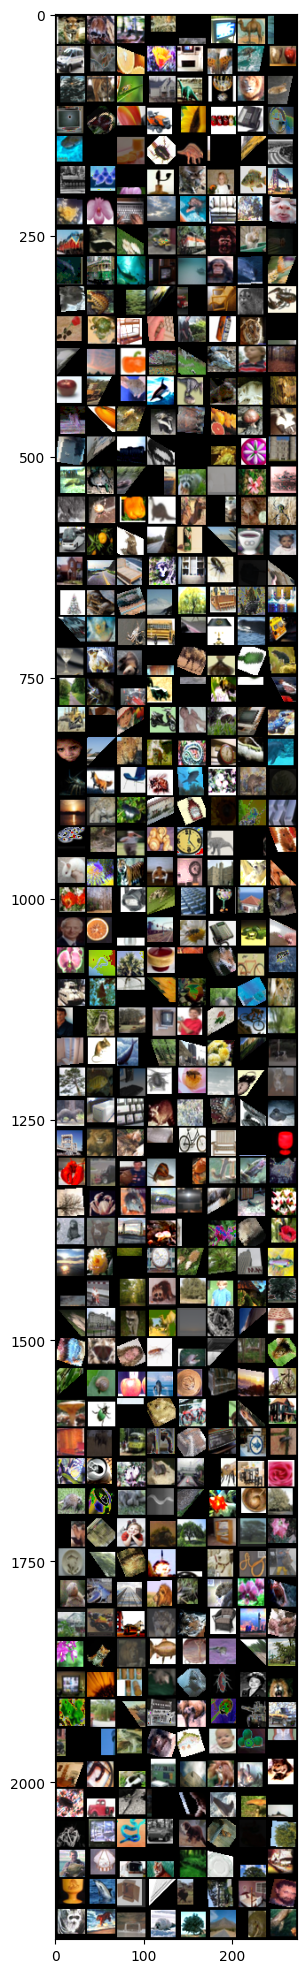

tiger shrew forest mouse pine_tree television camel otter bus   seal  orange poppy television butterfly turtle apple pine_tree tiger bee   house dinosaur cup   lion  rabbit television butterfly tulip lawn_mower sunflower can   telephone clock shark tank  orange cockroach dinosaur camel tractor road  tank  pear  orchid lamp  kangaroo baby  aquarium_fish bridge rose  orchid keyboard cloud dolphin couch oak_tree baby  train skunk mushroom motorcycle train raccoon squirrel beaver dolphin streetcar shark television ray   chimpanzee dolphin butterfly squirrel dinosaur pine_tree aquarium_fish bus   chair seal  lobster rose  turtle bed   keyboard man   can   tiger seal  chair cloud sweet_pepper maple_tree skunk crocodile boy   forest apple tractor flatfish dolphin dinosaur squirrel wolf  lobster kangaroo orange fox   skunk lobster orange mushroom skunk skyscraper bed   castle man   bus   dinosaur clock castle seal  shrew beaver sea   raccoon couch orchid tank  cloud spider sweet_pepper otter c

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 25))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# dataiter = iter(custom_trainloader)
# images, labels, confidences = next(dataiter)

# if training baseline model, uncomment this
dataiter = iter(baseline_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels 
# if isinstance(confidences, list):
#     # in case we have confidence 
#     confidences = confidences[1]
#     print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
# else:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
num_classes

100

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 200
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    
    net.train()
#     for i, (inputs, labels) in enumerate(baseline_trainloader):
    for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
#         only when TA with soft labels is applied
        if isinstance(confidences, list):
            confidences = confidences[1]
            
        # get the inputs
        inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
#         inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
#         print(f'pred: {outputs}\tlabel: {labels}\tconf: {confidences}')
#         hloss = criterion(outputs, labels)  
        loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hloss:.3f}')

        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/cifar100_net_ta_pytorch_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Loss: 3.690 - Test Accuracy:  4.940

Processing time:  69.468390 seconds.



Epoch 2 - Loss: 3.397 - Test Accuracy:  9.460

Processing time:  40.019862 seconds.



Epoch 3 - Loss: 3.183 - Test Accuracy:  13.330

Processing time:  19.859956 seconds.



Epoch 4 - Loss: 2.976 - Test Accuracy:  17.150

Processing time:  20.699471 seconds.



Epoch 5 - Loss: 2.742 - Test Accuracy:  19.680

Processing time:  20.291667 seconds.



Epoch 6 - Loss: 2.565 - Test Accuracy:  23.610

Processing time:  20.907062 seconds.



Epoch 7 - Loss: 2.406 - Test Accuracy:  22.050

Processing time:  20.217991 seconds.



Epoch 8 - Loss: 2.266 - Test Accuracy:  33.270

Processing time:  20.238554 seconds.



Epoch 9 - Loss: 2.157 - Test Accuracy:  36.040

Processing time:  20.208199 seconds.



Epoch 10 - Loss: 2.052 - Test Accuracy:  31.990

Processing time:  20.430827 seconds.



Epoch 11 - Loss: 1.961 - Test Accuracy:  39.310

Processing time:  20.204533 seconds.



Epoch 12 - Loss: 1.895 - Test Accuracy:  44.080

Processing time:  20.477082 seconds.



Epoch 13 - Loss: 1.837 - Test Accuracy:  32.320

Processing time:  20.634940 seconds.



Epoch 14 - Loss: 1.763 - Test Accuracy:  44.130

Processing time:  20.033866 seconds.



Epoch 15 - Loss: 1.706 - Test Accuracy:  46.710

Processing time:  20.427781 seconds.



Epoch 16 - Loss: 1.660 - Test Accuracy:  44.510

Processing time:  20.614875 seconds.



Epoch 17 - Loss: 1.606 - Test Accuracy:  43.830

Processing time:  20.388580 seconds.



Epoch 18 - Loss: 1.578 - Test Accuracy:  46.600

Processing time:  20.465161 seconds.



Epoch 19 - Loss: 1.538 - Test Accuracy:  54.630

Processing time:  20.793815 seconds.



Epoch 20 - Loss: 1.488 - Test Accuracy:  54.380

Processing time:  21.105218 seconds.



Epoch 21 - Loss: 1.452 - Test Accuracy:  51.010

Processing time:  20.376665 seconds.



Epoch 22 - Loss: 1.434 - Test Accuracy:  55.900

Processing time:  20.522950 seconds.



Epoch 23 - Loss: 1.399 - Test Accuracy:  56.180

Processing time:  20.363566 seconds.



Epoch 24 - Loss: 1.372 - Test Accuracy:  56.360

Processing time:  20.265162 seconds.



Epoch 25 - Loss: 1.344 - Test Accuracy:  55.920

Processing time:  19.931258 seconds.



Epoch 26 - Loss: 1.320 - Test Accuracy:  57.540

Processing time:  20.103920 seconds.



Epoch 27 - Loss: 1.296 - Test Accuracy:  59.280

Processing time:  21.037216 seconds.



Epoch 28 - Loss: 1.267 - Test Accuracy:  59.380

Processing time:  20.873551 seconds.



Epoch 29 - Loss: 1.245 - Test Accuracy:  60.790

Processing time:  20.324663 seconds.



Epoch 30 - Loss: 1.233 - Test Accuracy:  61.600

Processing time:  20.489913 seconds.



Epoch 31 - Loss: 1.209 - Test Accuracy:  60.630

Processing time:  20.753810 seconds.



Epoch 32 - Loss: 1.196 - Test Accuracy:  61.100

Processing time:  21.046578 seconds.



Epoch 33 - Loss: 1.181 - Test Accuracy:  59.660

Processing time:  20.799313 seconds.



Epoch 34 - Loss: 1.155 - Test Accuracy:  61.680

Processing time:  20.546229 seconds.



Epoch 35 - Loss: 1.135 - Test Accuracy:  64.320

Processing time:  20.407903 seconds.



Epoch 36 - Loss: 1.127 - Test Accuracy:  62.760

Processing time:  20.293265 seconds.



Epoch 37 - Loss: 1.125 - Test Accuracy:  63.960

Processing time:  20.567446 seconds.



Epoch 38 - Loss: 1.107 - Test Accuracy:  64.030

Processing time:  20.505868 seconds.



Epoch 39 - Loss: 1.084 - Test Accuracy:  64.390

Processing time:  20.346695 seconds.



Epoch 40 - Loss: 1.080 - Test Accuracy:  66.830

Processing time:  20.489946 seconds.



Epoch 41 - Loss: 1.070 - Test Accuracy:  65.360

Processing time:  20.442922 seconds.



Epoch 42 - Loss: 1.046 - Test Accuracy:  64.670

Processing time:  20.321154 seconds.



Epoch 43 - Loss: 1.037 - Test Accuracy:  63.780

Processing time:  20.237440 seconds.



Epoch 44 - Loss: 1.030 - Test Accuracy:  67.640

Processing time:  20.063799 seconds.



Epoch 45 - Loss: 1.007 - Test Accuracy:  65.600

Processing time:  20.329901 seconds.



Epoch 46 - Loss: 0.992 - Test Accuracy:  62.080

Processing time:  20.565328 seconds.



Epoch 47 - Loss: 0.994 - Test Accuracy:  66.990

Processing time:  20.236228 seconds.



Epoch 48 - Loss: 0.981 - Test Accuracy:  63.580

Processing time:  20.427814 seconds.



Epoch 49 - Loss: 0.980 - Test Accuracy:  67.220

Processing time:  20.497689 seconds.



Epoch 50 - Loss: 0.971 - Test Accuracy:  66.420

Processing time:  20.520164 seconds.



Epoch 51 - Loss: 0.956 - Test Accuracy:  64.310

Processing time:  20.230475 seconds.



Epoch 52 - Loss: 0.944 - Test Accuracy:  62.710

Processing time:  20.160454 seconds.



Epoch 53 - Loss: 0.935 - Test Accuracy:  66.710

Processing time:  20.408408 seconds.



Epoch 54 - Loss: 0.935 - Test Accuracy:  66.190

Processing time:  20.189778 seconds.



Epoch 55 - Loss: 0.926 - Test Accuracy:  67.170

Processing time:  20.079108 seconds.



Epoch 56 - Loss: 0.915 - Test Accuracy:  61.790

Processing time:  20.269635 seconds.



Epoch 57 - Loss: 0.905 - Test Accuracy:  68.840

Processing time:  20.306165 seconds.



Epoch 58 - Loss: 0.899 - Test Accuracy:  67.660

Processing time:  20.798230 seconds.



Epoch 59 - Loss: 0.877 - Test Accuracy:  66.190

Processing time:  20.275952 seconds.



Epoch 60 - Loss: 0.880 - Test Accuracy:  67.920

Processing time:  20.344058 seconds.



Epoch 61 - Loss: 0.876 - Test Accuracy:  65.470

Processing time:  20.365894 seconds.



Epoch 62 - Loss: 0.861 - Test Accuracy:  69.450

Processing time:  20.409984 seconds.



Epoch 63 - Loss: 0.851 - Test Accuracy:  67.830

Processing time:  20.536236 seconds.



Epoch 64 - Loss: 0.848 - Test Accuracy:  67.920

Processing time:  20.135785 seconds.



Epoch 65 - Loss: 0.849 - Test Accuracy:  65.070

Processing time:  20.995195 seconds.



Epoch 66 - Loss: 0.842 - Test Accuracy:  64.850

Processing time:  20.568986 seconds.



Epoch 67 - Loss: 0.824 - Test Accuracy:  69.860

Processing time:  20.198670 seconds.



Epoch 68 - Loss: 0.821 - Test Accuracy:  68.840

Processing time:  20.955420 seconds.



Epoch 69 - Loss: 0.812 - Test Accuracy:  65.700

Processing time:  20.927893 seconds.



Epoch 70 - Loss: 0.799 - Test Accuracy:  69.150

Processing time:  20.539244 seconds.



Epoch 71 - Loss: 0.801 - Test Accuracy:  70.810

Processing time:  20.173576 seconds.



Epoch 72 - Loss: 0.801 - Test Accuracy:  70.000

Processing time:  20.210815 seconds.



Epoch 73 - Loss: 0.785 - Test Accuracy:  69.750

Processing time:  20.493882 seconds.



Epoch 74 - Loss: 0.789 - Test Accuracy:  69.060

Processing time:  20.414455 seconds.



Epoch 75 - Loss: 0.771 - Test Accuracy:  69.750

Processing time:  20.674667 seconds.



Epoch 76 - Loss: 0.757 - Test Accuracy:  69.810

Processing time:  20.355245 seconds.



Epoch 77 - Loss: 0.764 - Test Accuracy:  70.850

Processing time:  20.358568 seconds.



Epoch 78 - Loss: 0.764 - Test Accuracy:  69.260

Processing time:  20.235647 seconds.



Epoch 79 - Loss: 0.737 - Test Accuracy:  69.980

Processing time:  19.974800 seconds.



Epoch 80 - Loss: 0.746 - Test Accuracy:  69.060

Processing time:  20.061089 seconds.



Epoch 81 - Loss: 0.736 - Test Accuracy:  71.230

Processing time:  20.603912 seconds.



Epoch 82 - Loss: 0.732 - Test Accuracy:  67.370

Processing time:  20.376792 seconds.



Epoch 83 - Loss: 0.720 - Test Accuracy:  67.020

Processing time:  20.606407 seconds.



Epoch 84 - Loss: 0.715 - Test Accuracy:  68.890

Processing time:  20.599497 seconds.



Epoch 85 - Loss: 0.705 - Test Accuracy:  70.110

Processing time:  20.311893 seconds.



Epoch 86 - Loss: 0.710 - Test Accuracy:  70.960

Processing time:  20.429051 seconds.



Epoch 87 - Loss: 0.694 - Test Accuracy:  70.490

Processing time:  20.452789 seconds.



Epoch 88 - Loss: 0.694 - Test Accuracy:  71.910

Processing time:  20.451759 seconds.



Epoch 89 - Loss: 0.683 - Test Accuracy:  71.180

Processing time:  20.863505 seconds.



Epoch 90 - Loss: 0.685 - Test Accuracy:  71.160

Processing time:  20.095418 seconds.



Epoch 91 - Loss: 0.685 - Test Accuracy:  70.770

Processing time:  20.531163 seconds.



Epoch 92 - Loss: 0.681 - Test Accuracy:  70.230

Processing time:  20.720587 seconds.



Epoch 93 - Loss: 0.662 - Test Accuracy:  71.150

Processing time:  20.793314 seconds.



Epoch 94 - Loss: 0.668 - Test Accuracy:  72.840

Processing time:  20.285273 seconds.



Epoch 95 - Loss: 0.656 - Test Accuracy:  71.930

Processing time:  20.701772 seconds.



Epoch 96 - Loss: 0.645 - Test Accuracy:  71.980

Processing time:  20.428795 seconds.



Epoch 97 - Loss: 0.636 - Test Accuracy:  68.420

Processing time:  20.230886 seconds.



Epoch 98 - Loss: 0.632 - Test Accuracy:  71.800

Processing time:  20.191164 seconds.



Epoch 99 - Loss: 0.637 - Test Accuracy:  70.070

Processing time:  20.448527 seconds.



Epoch 100 - Loss: 0.633 - Test Accuracy:  71.850

Processing time:  20.373732 seconds.



Epoch 101 - Loss: 0.620 - Test Accuracy:  73.230

Processing time:  20.730889 seconds.



Epoch 102 - Loss: 0.625 - Test Accuracy:  72.940

Processing time:  20.378572 seconds.



Epoch 103 - Loss: 0.610 - Test Accuracy:  70.260

Processing time:  20.330055 seconds.



Epoch 104 - Loss: 0.612 - Test Accuracy:  72.340

Processing time:  20.198644 seconds.



Epoch 105 - Loss: 0.603 - Test Accuracy:  73.290

Processing time:  19.969321 seconds.



Epoch 106 - Loss: 0.601 - Test Accuracy:  72.340

Processing time:  20.115771 seconds.



Epoch 107 - Loss: 0.594 - Test Accuracy:  72.870

Processing time:  20.241922 seconds.



Epoch 108 - Loss: 0.595 - Test Accuracy:  71.250

Processing time:  20.258137 seconds.



Epoch 109 - Loss: 0.588 - Test Accuracy:  73.090

Processing time:  20.310565 seconds.



Epoch 110 - Loss: 0.580 - Test Accuracy:  73.130

Processing time:  20.178153 seconds.



Epoch 111 - Loss: 0.578 - Test Accuracy:  73.340

Processing time:  20.251837 seconds.



Epoch 112 - Loss: 0.573 - Test Accuracy:  74.110

Processing time:  20.046450 seconds.



Epoch 113 - Loss: 0.568 - Test Accuracy:  73.930

Processing time:  20.643663 seconds.



Epoch 114 - Loss: 0.552 - Test Accuracy:  73.420

Processing time:  20.325087 seconds.



Epoch 115 - Loss: 0.557 - Test Accuracy:  74.230

Processing time:  20.536002 seconds.



Epoch 116 - Loss: 0.547 - Test Accuracy:  73.660

Processing time:  20.259254 seconds.



Epoch 117 - Loss: 0.543 - Test Accuracy:  73.150

Processing time:  20.341794 seconds.



Epoch 118 - Loss: 0.541 - Test Accuracy:  72.780

Processing time:  20.327441 seconds.



Epoch 119 - Loss: 0.529 - Test Accuracy:  74.160

Processing time:  20.320811 seconds.



Epoch 120 - Loss: 0.536 - Test Accuracy:  74.370

Processing time:  20.283993 seconds.



Epoch 121 - Loss: 0.526 - Test Accuracy:  75.180

Processing time:  20.385117 seconds.



Epoch 122 - Loss: 0.524 - Test Accuracy:  74.240

Processing time:  20.455244 seconds.



Epoch 123 - Loss: 0.518 - Test Accuracy:  74.190

Processing time:  20.986144 seconds.



Epoch 124 - Loss: 0.522 - Test Accuracy:  74.010

Processing time:  20.310879 seconds.



Epoch 125 - Loss: 0.514 - Test Accuracy:  74.930

Processing time:  20.338916 seconds.



Epoch 126 - Loss: 0.506 - Test Accuracy:  74.370

Processing time:  20.073736 seconds.



Epoch 127 - Loss: 0.495 - Test Accuracy:  75.240

Processing time:  20.307578 seconds.



Epoch 128 - Loss: 0.499 - Test Accuracy:  75.030

Processing time:  20.232473 seconds.



Epoch 129 - Loss: 0.501 - Test Accuracy:  75.220

Processing time:  20.318963 seconds.



Epoch 130 - Loss: 0.483 - Test Accuracy:  74.110

Processing time:  20.400647 seconds.



Epoch 131 - Loss: 0.479 - Test Accuracy:  74.920

Processing time:  20.378826 seconds.



Epoch 132 - Loss: 0.475 - Test Accuracy:  75.190

Processing time:  20.257128 seconds.



Epoch 133 - Loss: 0.475 - Test Accuracy:  74.850

Processing time:  20.187874 seconds.



Epoch 134 - Loss: 0.466 - Test Accuracy:  74.550

Processing time:  20.360355 seconds.



Epoch 135 - Loss: 0.466 - Test Accuracy:  75.390

Processing time:  20.273045 seconds.



Epoch 136 - Loss: 0.470 - Test Accuracy:  75.720

Processing time:  20.281391 seconds.



Epoch 137 - Loss: 0.462 - Test Accuracy:  74.810

Processing time:  21.183292 seconds.



Epoch 138 - Loss: 0.444 - Test Accuracy:  75.710

Processing time:  20.464680 seconds.



Epoch 139 - Loss: 0.452 - Test Accuracy:  75.610

Processing time:  20.271278 seconds.



Epoch 140 - Loss: 0.451 - Test Accuracy:  75.690

Processing time:  20.240925 seconds.



Epoch 141 - Loss: 0.444 - Test Accuracy:  75.850

Processing time:  20.333848 seconds.



Epoch 142 - Loss: 0.438 - Test Accuracy:  75.280

Processing time:  20.664354 seconds.



Epoch 143 - Loss: 0.434 - Test Accuracy:  76.280

Processing time:  20.167365 seconds.



Epoch 144 - Loss: 0.429 - Test Accuracy:  75.830

Processing time:  20.227389 seconds.



Epoch 145 - Loss: 0.429 - Test Accuracy:  76.230

Processing time:  20.149896 seconds.



Epoch 146 - Loss: 0.430 - Test Accuracy:  76.380

Processing time:  20.374155 seconds.



Epoch 147 - Loss: 0.429 - Test Accuracy:  76.060

Processing time:  20.572566 seconds.



Epoch 148 - Loss: 0.418 - Test Accuracy:  76.460

Processing time:  20.071541 seconds.



Epoch 149 - Loss: 0.417 - Test Accuracy:  75.930

Processing time:  20.146711 seconds.



Epoch 150 - Loss: 0.416 - Test Accuracy:  76.600

Processing time:  20.414661 seconds.



Epoch 151 - Loss: 0.403 - Test Accuracy:  76.550

Processing time:  20.127128 seconds.



Epoch 152 - Loss: 0.405 - Test Accuracy:  76.230

Processing time:  19.896622 seconds.



Epoch 153 - Loss: 0.397 - Test Accuracy:  77.600

Processing time:  19.878547 seconds.



Epoch 154 - Loss: 0.398 - Test Accuracy:  76.760

Processing time:  19.970601 seconds.



Epoch 155 - Loss: 0.392 - Test Accuracy:  76.860

Processing time:  20.572307 seconds.



Epoch 156 - Loss: 0.393 - Test Accuracy:  77.100

Processing time:  22.236439 seconds.



Epoch 157 - Loss: 0.383 - Test Accuracy:  77.130

Processing time:  19.594476 seconds.



Epoch 158 - Loss: 0.386 - Test Accuracy:  76.970

Processing time:  19.774709 seconds.



Epoch 159 - Loss: 0.386 - Test Accuracy:  77.310

Processing time:  20.730479 seconds.



Epoch 160 - Loss: 0.383 - Test Accuracy:  76.950

Processing time:  20.761965 seconds.



Epoch 161 - Loss: 0.384 - Test Accuracy:  77.280

Processing time:  20.421834 seconds.



Epoch 162 - Loss: 0.381 - Test Accuracy:  77.100

Processing time:  20.452667 seconds.



Epoch 163 - Loss: 0.372 - Test Accuracy:  77.620

Processing time:  20.629878 seconds.



Epoch 164 - Loss: 0.379 - Test Accuracy:  77.390

Processing time:  20.344024 seconds.



Epoch 165 - Loss: 0.372 - Test Accuracy:  77.870

Processing time:  20.139783 seconds.



Epoch 166 - Loss: 0.369 - Test Accuracy:  77.780

Processing time:  20.522070 seconds.



Epoch 167 - Loss: 0.362 - Test Accuracy:  77.630

Processing time:  20.409504 seconds.



Epoch 168 - Loss: 0.366 - Test Accuracy:  77.450

Processing time:  20.619208 seconds.



Epoch 169 - Loss: 0.367 - Test Accuracy:  77.920

Processing time:  21.168115 seconds.



Epoch 170 - Loss: 0.356 - Test Accuracy:  77.810

Processing time:  20.407738 seconds.



Epoch 171 - Loss: 0.358 - Test Accuracy:  77.710

Processing time:  20.321051 seconds.



Epoch 172 - Loss: 0.355 - Test Accuracy:  77.540

Processing time:  20.239699 seconds.



Epoch 173 - Loss: 0.357 - Test Accuracy:  77.820

Processing time:  20.622066 seconds.



Epoch 174 - Loss: 0.352 - Test Accuracy:  77.770

Processing time:  20.385662 seconds.



Epoch 175 - Loss: 0.352 - Test Accuracy:  78.090

Processing time:  20.526207 seconds.



Epoch 176 - Loss: 0.354 - Test Accuracy:  78.170

Processing time:  20.403056 seconds.



Epoch 177 - Loss: 0.350 - Test Accuracy:  77.910

Processing time:  20.702215 seconds.



Epoch 178 - Loss: 0.351 - Test Accuracy:  77.950

Processing time:  20.247986 seconds.



Epoch 179 - Loss: 0.345 - Test Accuracy:  78.020

Processing time:  20.303248 seconds.



Epoch 180 - Loss: 0.351 - Test Accuracy:  77.990

Processing time:  20.137826 seconds.



Epoch 181 - Loss: 0.339 - Test Accuracy:  77.890

Processing time:  20.197870 seconds.



Epoch 182 - Loss: 0.346 - Test Accuracy:  78.030

Processing time:  20.261890 seconds.



Epoch 183 - Loss: 0.340 - Test Accuracy:  77.940

Processing time:  19.964894 seconds.



Epoch 184 - Loss: 0.344 - Test Accuracy:  77.910

Processing time:  20.143885 seconds.



Epoch 185 - Loss: 0.341 - Test Accuracy:  77.980

Processing time:  20.298312 seconds.



Epoch 186 - Loss: 0.344 - Test Accuracy:  78.070

Processing time:  20.076298 seconds.



Epoch 187 - Loss: 0.341 - Test Accuracy:  78.100

Processing time:  22.732265 seconds.



Epoch 188 - Loss: 0.345 - Test Accuracy:  77.970

Processing time:  20.169709 seconds.



Epoch 189 - Loss: 0.331 - Test Accuracy:  78.110

Processing time:  20.306997 seconds.



Epoch 190 - Loss: 0.338 - Test Accuracy:  78.170

Processing time:  20.060303 seconds.



Epoch 191 - Loss: 0.333 - Test Accuracy:  78.180

Processing time:  20.176316 seconds.



Epoch 192 - Loss: 0.335 - Test Accuracy:  78.100

Processing time:  20.367272 seconds.



Epoch 193 - Loss: 0.333 - Test Accuracy:  77.910

Processing time:  21.293719 seconds.



Epoch 194 - Loss: 0.333 - Test Accuracy:  78.250

Processing time:  20.491588 seconds.



Epoch 195 - Loss: 0.335 - Test Accuracy:  78.100

Processing time:  20.545183 seconds.



Epoch 196 - Loss: 0.334 - Test Accuracy:  77.910

Processing time:  20.311782 seconds.



Epoch 197 - Loss: 0.332 - Test Accuracy:  77.990

Processing time:  20.037993 seconds.



Epoch 198 - Loss: 0.333 - Test Accuracy:  77.980

Processing time:  20.357919 seconds.



Epoch 199 - Loss: 0.333 - Test Accuracy:  78.200

Processing time:  20.264399 seconds.



Epoch 200 - Loss: 0.335 - Test Accuracy:  78.060

Processing time:  20.256432 seconds.
Finished Training


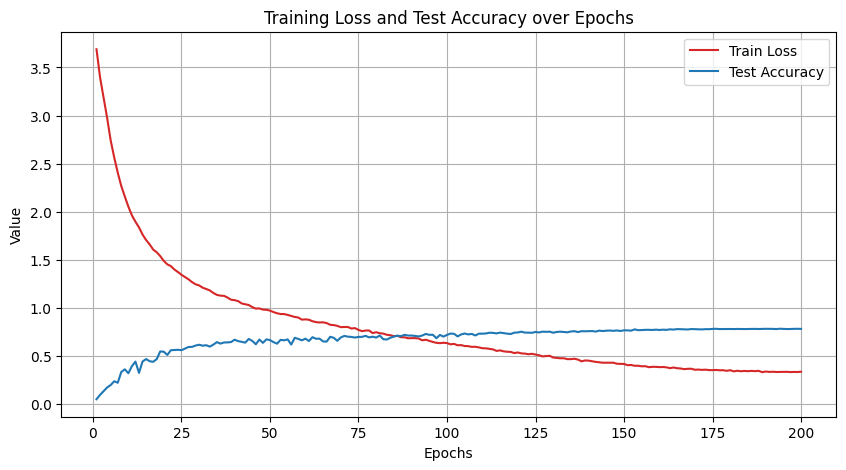

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
# #         np_data_c = np.load(f'/kaggle/input/cifar-10-c/{corruption}.npy')

#         np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 78.06 %
